In [1]:
# import modules needed
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
# read data
df = pd.read_csv('df_cleaned.csv')
df.head()

,title,authors,year_published,number,volume,journal,type,content,doi,file,cleaned_content
0,Contrastive autoencoder for anomaly detection ...,Hao Zhou and Ke Yu and Xuan Zhang and Guanlin ...,2022,NaN,610,Information Sciences,article,Contrastive autoencoder for anomaly detection ...,https://doi.org/10.1016/j.ins.2022.07.179,doc16,Contrastive autoencoder for anomaly detection ...
1,Detection of abnormality in wireless capsule e...,Samir Jain and Ayan Seal and Aparajita Ojha an...,2020,NaN,127,Computers in Biology and Medicine,article,Computers in Biology and Medicine 127 (2020) 1...,https://doi.org/10.1016/j.compbiomed.2020.104094,doc17,Computers in Biology and Medicine 127 (2020) 1...
2,Single image dehazing using a new color channel,Geet Sahu and Ayan Seal and Ondrej Krejcar and...,2021,NaN,74,Journal of Visual Communication and Image Repr...,article,J. Vis. Commun. Image R. 74 (2021) 103008\nAva...,https://doi.org/10.1016/j.jvcir.2020.103008,doc15,J. Vis. Commun. Image R. 74 (2021) 103008 Avai...
3,Estimating Tukey depth using incremental quant...,Hugo L. Hammer and Anis Yazidi and Håvard Rue,2022,NaN,122,Pattern Recognition,article,Pattern Recognition 122 (2022) 108339 \nConten...,https://doi.org/10.1016/j.patcog.2021.108339,doc29,Pattern Recognition 122 (2022) 108339 Contents...
4,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,NaN,NaN,NaN,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28,Advanced Passive Operating System Fingerprinti...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            37 non-null     object 
 1   authors          37 non-null     object 
 2   year_published   37 non-null     int64  
 3   number           12 non-null     float64
 4   volume           30 non-null     object 
 5   journal          31 non-null     object 
 6   type             37 non-null     object 
 7   content          37 non-null     object 
 8   doi              33 non-null     object 
 9   file             37 non-null     object 
 10  cleaned_content  37 non-null     object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.3+ KB


In [4]:
# investigate basic statistics
df['text_length'] = df['cleaned_content'].apply(len)  
df['text_length'].describe() 


count        37.000000
mean      57268.081081
std       20525.805071
min       23349.000000
25%       42613.000000
50%       57919.000000
75%       69879.000000
max      110930.000000
Name: text_length, dtype: float64

In [5]:
# list of words to remove
stop_words = set(ENGLISH_STOP_WORDS)  

# tokenize the text and remove stop words, punctuation, and numbers
words = ' '.join(df['cleaned_content']).split()
filtered_words = [
    word for word in words 
    if word.lower() not in stop_words and word not in string.punctuation and not word.isdigit()
]

# count word frequencies
word_counts = Counter(filtered_words)

# top 20 most common words
common_words = word_counts.most_common(20)
print(common_words)

[('et', 977), ('using', 868), ('data', 830), ('al.', 645), ('learning', 603), ('used', 594), ('based', 574), ('J.', 554), ('model', 551), ('A.', 524), ('M.', 500), ('different', 489), ('method', 479), ('time', 477), ('Fig.', 439), ('results', 433), ('proposed', 428), ('number', 422), ('S.', 420), ('network', 405)]


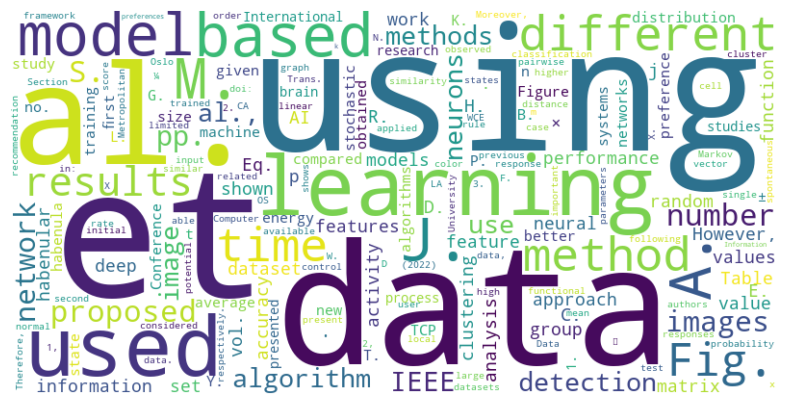

In [6]:
# create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

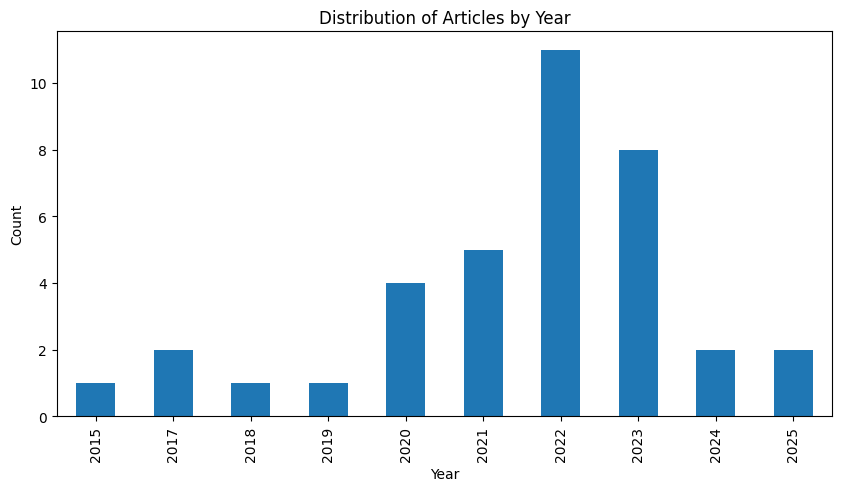

In [7]:
# amount of articles extracted for each year
df['year_published'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [8]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['cleaned_content'])

# extract top 20 bigrams
bigram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(bigram_df.sum(axis=0).sort_values(ascending=False).head(20)) 


et al                       1008
10 10                        213
deep learning                204
machine learning             188
doi 10                       159
covid 19                     147
proposed method              143
neural network               142
oslo metropolitan            130
metropolitan university      129
habenular neurons            113
tcp variant                  109
neural networks              107
precision recall             104
ieee trans                   101
international conference      99
f1 score                      99
time series                   97
oslomet oslo                  95
spontaneous activity          91
dtype: int64


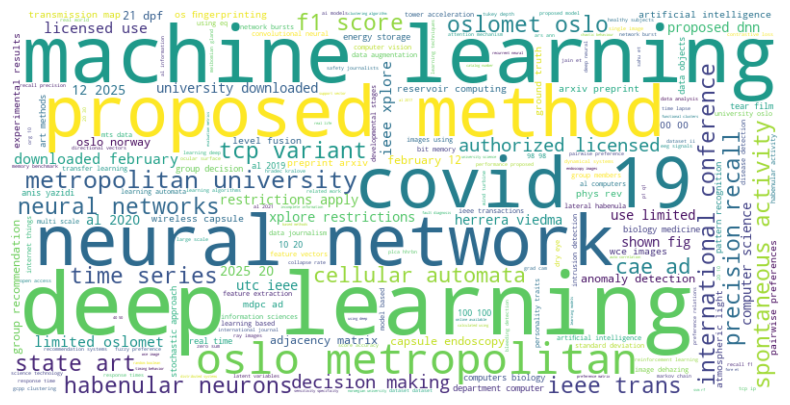

In [9]:
# words to exclude from bigram
stop_words = ['et al', '10 10', 'doi']

# extract bigrams without limiting the number of features
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['cleaned_content'])
bigram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# get all bigrams
all_bigrams = bigram_df.sum(axis=0)

# filter out the unwanted bigrams
filtered_bigrams = all_bigrams[~all_bigrams.index.str.contains('|'.join(stop_words))]

# create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_bigrams.to_dict())

# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()